- https://pytorch.org/vision/stable/models.html
- https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang

In [1]:
!nvidia-smi

Sun Apr 11 17:09:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# params

In [2]:
HOME = "/data/git/shopee-product-matching"
pcomp = f'{HOME}/input/shopee-product-matching'

# IMGSZ = 224
NWKRS = 8
BS = 32

import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
PIN_MEMORY = True if DEVICE == torch.device("cuda") else False

# code

In [3]:
import matplotlib.pyplot as plt

## utils

In [4]:
import numpy as np

def getf1(x, y):
    n = len(np.intersect1d(x, y))
    return 2 * n / (len(x) + len(y))


def getf1s(xs, ys):
    return (getf1(x, y) for x, y in zip(xs, ys))


def meanf1(xs, ys):
    return np.mean(list(getf1s(xs, ys)))


def get_targets(df):
    grp2ids = df.groupby("label_group").posting_id.agg("unique").to_dict()
    targets = df.label_group.map(grp2ids)
    return targets

def preds2pids(preds, pids):
    return [pids[o] for o in preds]


def comb_preds(*preds):
    return (np.unique(np.concatenate(l)) for l in zip(*preds))


## vision

In [5]:
import pandas as pd
import torchvision
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, TensorDataset, DataLoader
from tqdm import tqdm


class VDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.filepath[idx]
        img = Image.open(img_path)
        img = self.transforms(img)
        return img
    

def mk_tfms(imgsz):
    # https://github.com/lukemelas/EfficientNet-PyTorch
    tfms = transforms.Compose(
    [
        transforms.Resize((imgsz, imgsz)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return tfms


def mk_dl(df, tfms):
    ds = VDataset(df, tfms)
    dl = DataLoader(
        dataset=ds,
        batch_size=BS,
        num_workers=NWKRS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
    )
    return dl

# https://discuss.pytorch.org/t/how-to-delete-layer-in-pretrained-model/17648/2?u=yang-zhang
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def mk_embedder(mdl):
    if isinstance(mdl, torchvision.models.resnet.ResNet):
        mdl.fc = Identity()
    if isinstance(mdl, EfficientNet):
        def extract_feats(input_):
            return mdl.extract_features(input_).mean(dim=(-1, -2))
        mdl.forward = extract_feats
    return mdl


def mk_feats(dl, mdl):
    device = torch.device(DEVICE)
    mdl = mdl.to(device)
    mdl.eval()
    lst = []
    for dat in tqdm(dl, total=len(dl)):
        with torch.no_grad():
            fts = mdl(dat.to(device))
        lst.append(fts.cpu().detach().numpy())
    feats = np.concatenate(lst)
    return feats

## neighbor

In [6]:
from cuml.neighbors import NearestNeighbors
import numpy as np

N_NBRS = 50
CHUNK = 1024 * 4


def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS, metric="cosine")
    nnmdl.fit(feats)
    return nnmdl


def get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype="float")
    idx = np.zeros((n, n_nbrs), dtype="int")
    n_chunks = len(feats) // sz_chunk
    if len(feats) % sz_chunk != 0:
        n_chunks += 1
    for j in tqdm(range(n_chunks)):
        a = j * sz_chunk
        b = (j + 1) * sz_chunk
        b = min(b, len(feats))
        dists_, idx_ = nnmdl.kneighbors(
            feats[
                a:b,
            ]
        )
        dists[a:b] = dists_
        idx[a:b] = idx_
    return dists, idx


def get_nbrs(feats, n_nbrs=N_NBRS, sz_chunk=CHUNK):
    nnmdl = mk_nnmdl(feats, n_nbrs)
    dists, idx = get_nbrs_from_nnmdl(feats, nnmdl, sz_chunk)
    return dists, idx


def get_preds_by_thrsh(dists, idx, thrsh):
    preds = (ind[dst < thrsh] for dst, ind in zip(dists, idx))
    return preds


def find_best(dists, idx, thrshes=np.linspace(0.,1.,num=21)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    res = {'f1_best': f1_best, 
           'thrsh_best': thrsh_best, 
           'preds_best': preds_best, 
           'thrshes': thrshes, 
           'f1_lst': f1_lst}
    return res

# run

In [7]:
df = pd.read_csv(f'{pcomp}/train.csv')
df['filepath'] = f"{pcomp}/train_images/"+df.image
pids = df.posting_id.values
targets = get_targets(df)



In [8]:
df.shape

(34250, 6)

In [9]:
df.head()

,posting_id,image,image_phash,title,label_group,filepath
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/data/git/shopee-product-matching/input/shopee...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/data/git/shopee-product-matching/input/shopee...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/data/git/shopee-product-matching/input/shopee...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/data/git/shopee-product-matching/input/shopee...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/data/git/shopee-product-matching/input/shopee...


In [10]:
nm2mdlsz = {
#     'resnet18': torchvision.models.resnet18(pretrained=True),
#     'resnet34': torchvision.models.resnet34(pretrained=True),
#     'resnet50': torchvision.models.resnet50(pretrained=True),
#     'resnet101': torchvision.models.resnet101(pretrained=True),
#     'resnet152': torchvision.models.resnet152(pretrained=True),
#     'resnext50_32x4d': torchvision.models.resnext50_32x4d(pretrained=True),
#     'resnext101_32x8d': torchvision.models.resnext101_32x8d(pretrained=True),
    "efficientnet-b0": (EfficientNet.from_pretrained("efficientnet-b0"), 224),
#     "efficientnet-b1": (EfficientNet.from_pretrained("efficientnet-b1"), 256),
    "efficientnet-b2": (EfficientNet.from_pretrained("efficientnet-b2"), 256),
#     "efficientnet-b3": EfficientNet.from_pretrained("efficientnet-b3"), 512,
#     "efficientnet-b4": EfficientNet.from_pretrained("efficientnet-b4"), 512,
    "efficientnet-b5": (EfficientNet.from_pretrained("efficientnet-b5"), 512),
#     "efficientnet-b6": EfficientNet.from_pretrained("efficientnet-b6"),
#     "efficientnet-b7": EfficientNet.from_pretrained("efficientnet-b7"),
}

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b5


In [11]:
nm2feats = {}
for nm,(mdl,imgsz) in nm2mdlsz.items():
    mdl = mk_embedder(mdl)
    tfms = mk_tfms(imgsz)
    dl = mk_dl(df, tfms)
    feats = mk_feats(dl, mdl)
    nm2feats[nm] = feats

100%|██████████| 1071/1071 [05:46<00:00,  3.09it/s]


In [12]:
nm2nbrs = {nm: get_nbrs(feats) for nm,feats in nm2feats.items()}

100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


efficientnet-b0, 0.665, 0.20 


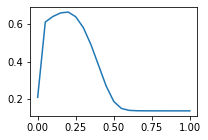

100%|██████████| 21/21 [00:32<00:00,  1.57s/it]


efficientnet-b2, 0.667, 0.25 


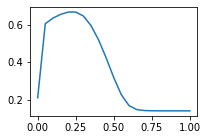

100%|██████████| 21/21 [00:34<00:00,  1.65s/it]


efficientnet-b5, 0.658, 0.15 


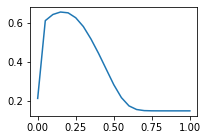

In [13]:
nm2res = {}
for nm, (dists, idx) in nm2nbrs.items():
    nm, (dists, idx)
    res = find_best(dists, idx)
    nm2res[nm] = res
    print(f"{nm}, {res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")
    plt.figure(figsize=(3,2))
    plt.plot(res['thrshes'], res['f1_lst'])  
    plt.show()


In [14]:
pd.DataFrame([(nm,res['f1_best'],res['thrsh_best']) for nm, res in nm2res.items()])

,0,1,2
0,efficientnet-b0,0.664918,0.20
1,efficientnet-b2,0.666787,0.25
2,efficientnet-b5,0.657628,0.15


# union results

In [15]:
preds_esmb = comb_preds(*(o['preds_best'] for o in nm2res.values()))

In [16]:
meanf1(preds_esmb,targets)

0.6617569773407611

# concat

In [17]:
feats_conc = np.concatenate(list(nm2feats.values()), 1)

In [18]:
feats_conc.shape

(34250, 4736)

In [19]:
nbrs = get_nbrs(feats_conc)

100%|██████████| 9/9 [00:02<00:00,  3.34it/s]


100%|██████████| 21/21 [00:33<00:00,  1.59s/it]


0.672, 0.20 


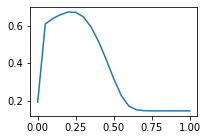

In [20]:
dists, idx = nbrs
res = find_best(dists, idx)
print(f"{res['f1_best']:.3f}, {res['thrsh_best']:.2f} ")
plt.figure(figsize=(3,2))
plt.plot(res['thrshes'], res['f1_lst'])  
plt.show()


# fin

In [21]:
!nvidia-smi

Sun Apr 11 17:31:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    39W / 300W |   9880MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  